In [1]:
import pandas as pd

In [2]:
import os.path

In [3]:
import numpy as np

In [4]:
import os

In [5]:
import time
import datetime

In [6]:
import matplotlib.pyplot as plt

In [7]:
from tqdm.notebook import tqdm

In [8]:
import sys

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [10]:
from tqdm.keras import TqdmCallback

In [11]:
from math import sqrt
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,Model
from keras.layers import Dense, Input,BatchNormalization
from keras.layers import LSTM

In [12]:
from random import shuffle

In [13]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [14]:
reset_keras()

W0322 22:33:27.587640 140108542539584 deprecation_wrapper.py:119] From /lustre/home/adrianodif/Tools/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0322 22:33:27.589974 140108542539584 deprecation_wrapper.py:119] From /lustre/home/adrianodif/Tools/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0322 22:33:27.591362 140108542539584 deprecation_wrapper.py:119] From /lustre/home/adrianodif/Tools/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0322 22:33:31.755778 140108542539584 deprecation_wrapper.py:119] From /lustre/home/adrianodif/Tools/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/

0


## Grouping Stocks

In [15]:
group_path = "stock_groups/"
groups = os.listdir(group_path)

In [16]:
group_df = pd.DataFrame([])
for n,f in enumerate(groups):
    df = pd.read_html(group_path + f)[0]
    df["Sector"] = f.split(".")[0]
    df["Sector_id"] = n
    group_df = pd.concat([group_df,df])

In [17]:
group_df.head()

,Change%,Company,Company.1,Price,Volume,Low,High,Sector,Sector_id
0,▲ 1.42%,TXG,"10x Genomics, Inc",55.78,1342500,52.510,56.78,healthcare,0
1,▲ 5.54%,YI,"111, Inc",6.10,49700,5.620,6.20,healthcare,0
2,▲ 18.05%,ONEM,1Life Healthcare Inc.,19.49,4063900,16.810,21.88,healthcare,0
3,▼ -1.00%,XXII,"22nd Century Group, Inc",0.69,1202700,0.690,0.74,healthcare,0
4,▲ 19.92%,ETNB,89bio Inc,23.54,212500,17.204,23.86,healthcare,0


In [18]:
def unixdate(x):
    return datetime.datetime.timestamp(x)

In [19]:
def normaldate(x):
    return datetime.datetime.utcfromtimestamp(x*3600).strftime('%d-%m-%Y')

In [20]:
def smartsort(x):
    try:
        return int(x.split(".")[0])
    except:
        return x.split(".")[0]

In [21]:
csv_path = "../historic_data/csv/"
files = os.listdir(csv_path)
numeric_files = [f for f in files if f.split(".")[0].isnumeric()]
alpha_files = [f for f in files if not f.split(".")[0].isnumeric()]
numeric_files.sort(key=smartsort)
alpha_files.sort(key=smartsort)

In [22]:
min_day = datetime.datetime.strptime("3000-01-01","%Y-%m-%d")
max_day = datetime.datetime.strptime("1900-01-01","%Y-%m-%d") 
max_min_day = datetime.datetime.strptime("1900-01-01","%Y-%m-%d")

In [673]:
n_stocks = 50
min_days = 365*20 

In [24]:
selected_sector = 0

In [25]:
shuffle(files)

In [26]:
n = 0

selected_files = []

for f in tqdm(files):
    
    if n >= n_stocks:
        continue
        
    st = ".".join(f.split(".")[:-1])
    
    if not st in group_df["Company"].values:
        continue
    
    #if not group_df[group_df["Company"]==st]["Sector_id"].values[0]==selected_sector:
        #continue
        
    df = pd.read_csv(csv_path + f)
    
    df["Date"] = pd.to_datetime(df['Date'])
    
    this_min = df['Date'].min()
    this_max = df['Date'].max()
    
    if (this_max-this_min).days < min_days:
        continue
    
    selected_files.append(f)
    n = n + 1 
    
    max_min_day = max(max_min_day,this_min)
    min_day = min(min_day,this_min)
    max_day = max(max_day,this_max)

In [814]:
min_day = datetime.datetime.strptime("1995-01-01","%Y-%m-%d")
max_day = datetime.datetime.strptime("2020-01-01","%Y-%m-%d") 
#max_min_day = datetime.datetime.strptime("1900-01-01","%Y-%m-%d")

all_days = pd.date_range(min_day,max_day,freq="1D")

def fill_date(x,col="Date"):
    adf = pd.DataFrame(dict(Date = all_days.difference(pd.Index(x[col]))),columns=x.columns)
    #adf['visit'] = 0
    return x.append(adf,ignore_index=True).sort_values(by=col).bfill()

In [654]:
last_date = datetime.datetime.strptime("2020-01-01","%Y-%m-%d") #datetime.datetime.today()

In [655]:
print("Selected %d stocks"%(len(selected_files)))

Selected 50 stocks


In [854]:
dfs = []
theCols = []
n = 0
for f in tqdm(selected_files):
    
    st = ".".join(f.split(".")[:-1])
    
    if not st in group_df["Company"].values:
        continue

    
    sec_id = group_df[group_df["Company"]==st]["Sector_id"].values[0]
    sec = group_df[group_df["Company"]==st]["Sector"].values[0]
    
    df = pd.read_csv(csv_path + f)
    df["Date"] = pd.to_datetime(df['Date'])
    
    #print(df["Date"].max())
    if df["Date"].max()<max_day:
        continue
    if df.isnull().values.any():
        continue
        
        
    df = df[df["Date"]<=max_day]
    df = df[df["Date"]>=min_day]
    
    df["Stock"] = st
    df["Stock_id"] = n
    df["Sector"] = sec
    df["Sector_id"] = sec_id
    
    df = fill_date(df)
    
    df["Unix_date"] = df["Date"].apply(unixdate)
    df["Unix_date"] = (df["Unix_date"] - df["Unix_date"].min())/3600.0
    
    #print(df["Open"].head(n=-1))
    df = df.sort_values("Unix_date")
    #print(df.head(n=-1))
    theCols = df.columns
    
    df.columns =  [ f + "_" + str(n) for f in theCols]
    
    dfs.append(df)
    n = n + 1
    
num_stocks = n
stocks_timeser = pd.concat(dfs,axis=1)
for df in dfs:
    df.columns = theCols
stocks = pd.concat(dfs)
#dfs = []

In [868]:
stocks_timeser = stocks_timeser.sort_values("Date_0").reset_index()

In [821]:
new_df = stocks.groupby("Stock").apply(fill_date)

In [822]:
new_df.head()

Date       Low      Open     Volume      High     Close  \
Stock                                                                   
AFL   0 1995-01-01  2.885417  2.906250  1616000.0  2.927083  2.916667   
      1 1995-01-02  2.885417  2.906250  1616000.0  2.927083  2.916667   
      2 1995-01-03  3.052083  3.135417  1540800.0  3.135417  3.062500   
      3 1995-01-04  3.364583  3.447917  1622400.0  3.468750  3.364583   
      4 1995-01-05  3.364583  3.447917  1622400.0  3.468750  3.364583   

         Adjusted Close Stock  Stock_id              Sector  Sector_id  \
Stock                                                                    
AFL   0        0.938784   AFL      32.0  financial-services        8.0   
      1        0.938784   AFL      32.0  financial-services        8.0   
      2        1.023583   AFL      32.0  financial-services        8.0   
      3        1.124548   AFL      32.0  financial-services        8.0   
      4        1.124548   AFL      32.0  financial-services        8.0   

         Unix_date  
Stock               
AFL   0        0.0  
      1       24.0  
      2       48.0  
      3       72.0  
      4       96.0

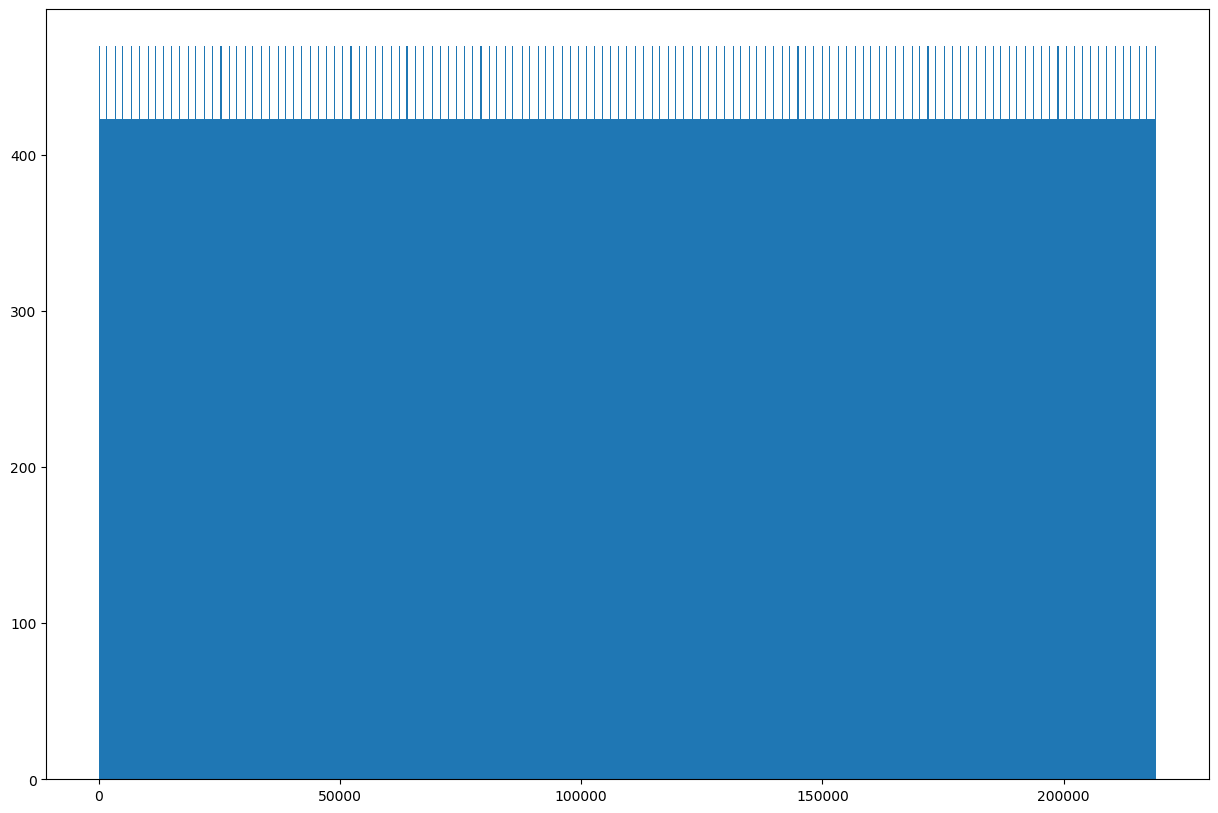

In [679]:
fig = plt.figure(figsize=(15,10))
plt.hist(new_df["Unix_date"].values,bins=1000);

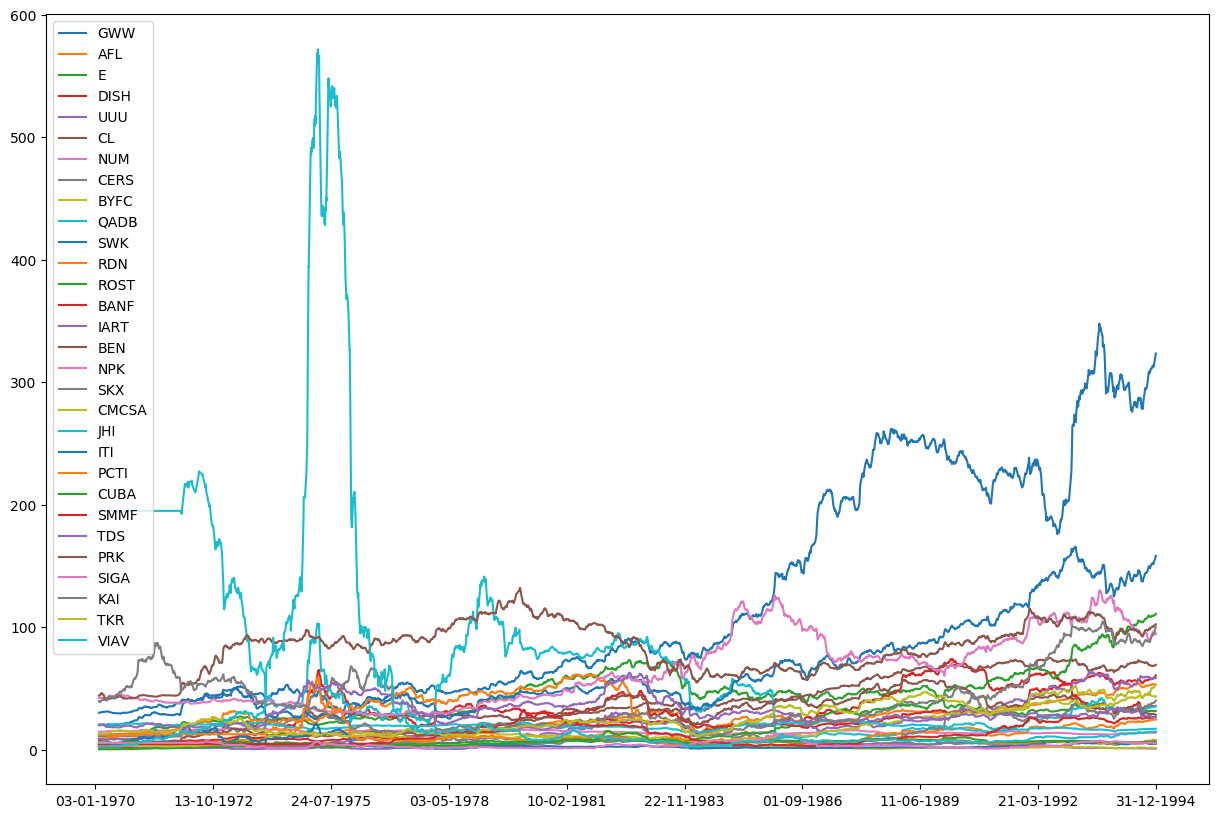

In [689]:
fig = plt.figure(figsize=(15,10))

ax = fig.gca()
for f in new_df["Stock"].value_counts().keys()[0:30]:
    cut = (new_df["Stock"]==f) & (new_df["Date"]>"1995-01-02") & (new_df["Date"]<"2020-02-01") 
    
    X = new_df[cut]["Unix_date"].values
    y = new_df[cut]["High"].values
    
    med = 30
    Y = np.zeros(len(y)-med)
    
    for i in range(med):

        Y = Y + y[med-1-i:-i-1]
         #Y2 = Y[2:]
    
    Y = Y/med
    
    plt.plot(X[med:],Y,"-",label=f);

plt.legend()
T = np.linspace(new_df[cut]["Unix_date"].min(),new_df[cut]["Unix_date"].max(),10);
#plt.yscale("log");
plt.xticks(T,np.vectorize(normaldate)(T));

In [819]:
new_df.head()

Date       Low      Open     Volume      High     Close  \
Stock                                                                   
AFL   0 1995-01-01  2.885417  2.906250  1616000.0  2.927083  2.916667   
      1 1995-01-02  2.885417  2.906250  1616000.0  2.927083  2.916667   
      2 1995-01-03  3.052083  3.135417  1540800.0  3.135417  3.062500   
      3 1995-01-04  3.364583  3.447917  1622400.0  3.468750  3.364583   
      4 1995-01-05  3.364583  3.447917  1622400.0  3.468750  3.364583   

         Adjusted Close Stock  Stock_id              Sector  Sector_id  \
Stock                                                                    
AFL   0        0.938784   AFL      32.0  financial-services        8.0   
      1        0.938784   AFL      32.0  financial-services        8.0   
      2        1.023583   AFL      32.0  financial-services        8.0   
      3        1.124548   AFL      32.0  financial-services        8.0   
      4        1.124548   AFL      32.0  financial-services        8.0   

         Unix_date  
Stock               
AFL   0        0.0  
      1       24.0  
      2       48.0  
      3       72.0  
      4       96.0

In [691]:
good_cols = ['Low', 'Open', 'Volume', 'High', 'Close']

In [852]:
stocks_timeser.head()

,Date_0,Low_0,Open_0,Volume_0,High_0,Close_0,Adjusted Close_0,Stock_0,Stock_id_0,Sector_0,...,Open_46,Volume_46,High_46,Close_46,Adjusted Close_46,Stock_46,Stock_id_46,Sector_46,Sector_id_46,Unix_date_46
0,1995-03-01,7.18750,7.18750,24000.0,7.31250,7.31250,6.647963,RDN,0.0,financial-services,...,12.34375,38000.0,12.34375,12.15625,12.15625,ROG,46.0,technology,6.0,1416.0
1,1995-04-01,7.34375,7.34375,33600.0,7.40625,7.40625,6.733192,RDN,0.0,financial-services,...,12.21875,52800.0,12.21875,12.21875,12.21875,ROG,46.0,technology,6.0,2159.0
2,1995-05-01,7.40625,7.40625,12000.0,7.43750,7.43750,6.761602,RDN,0.0,financial-services,...,12.21875,15200.0,12.21875,12.06250,12.06250,ROG,46.0,technology,6.0,2879.0
3,1995-06-01,7.40625,7.43750,12400.0,7.43750,7.40625,6.733192,RDN,0.0,financial-services,...,12.09375,6400.0,12.09375,12.03125,12.03125,ROG,46.0,technology,6.0,3623.0
4,1995-09-01,7.43750,7.43750,243200.0,7.50000,7.46875,6.790016,RDN,0.0,financial-services,...,12.09375,16800.0,12.12500,12.12500,12.12500,ROG,46.0,technology,6.0,5831.0


In [298]:
stocks_timeser[[col for col in stocks_timeser.columns if "Date" in col]].head(n=-1)

,Date_0,Date_1,Date_2,Date_3,Date_4,Date_5,Date_6,Date_7,Date_8,Date_9,...,Date_40,Date_41,Date_42,Date_43,Date_44,Date_45,Date_46,Date_47,Date_48,Date_49
0,1995-03-01,1995-03-01,1995-03-01,1995-03-01,1995-03-01,1995-03-01,1995-08-16,1995-03-01,1995-03-01,1995-03-01,...,1995-11-28,1995-03-01,1995-03-01,1995-03-01,1995-03-01,1997-10-31,1996-09-01,1995-03-01,1999-10-08,1995-03-01
1,1995-04-01,1995-04-01,1995-04-01,1995-04-01,1995-04-01,1995-04-01,1995-08-17,1995-04-01,1995-04-01,1995-04-01,...,1995-11-29,1995-04-01,1995-04-01,1995-04-01,1995-04-01,1997-03-11,1996-10-01,1995-04-01,1999-11-08,1995-04-01
2,1995-05-01,1995-05-01,1995-05-01,1995-05-01,1995-05-01,1995-05-01,1995-08-18,1995-05-01,1995-05-01,1995-05-01,...,1995-11-30,1995-05-01,1995-05-01,1995-05-01,1995-05-01,1997-04-11,1996-11-01,1995-05-01,1999-12-08,1995-05-01
3,1995-06-01,1995-06-01,1995-06-01,1995-06-01,1995-06-01,1995-06-01,1995-08-21,1995-06-01,1995-06-01,1995-06-01,...,1995-01-12,1995-06-01,1995-06-01,1995-06-01,1995-06-01,1997-05-11,1996-12-01,1995-06-01,1999-08-13,1995-06-01
4,1995-09-01,1995-09-01,1995-09-01,1995-09-01,1995-09-01,1995-09-01,1995-08-22,1995-09-01,1995-09-01,1995-09-01,...,1995-04-12,1995-09-01,1995-09-01,1995-09-01,1995-09-01,1997-06-11,1996-01-15,1995-09-01,1999-08-16,1995-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9126,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,...,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21,2019-12-21
9127,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,...,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22,2019-12-22
9128,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,...,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25,2019-12-25
9129,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,...,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28,2019-12-28


In [341]:
stocks_timeser[[col for col in stocks_timeser.columns if "Volume" in col]].head(n=-1)

,Volume_0,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,...,Volume_37,Volume_38,Volume_39,Volume_40,Volume_41,Volume_42,Volume_43,Volume_44,Volume_45,Volume_46
0,24000.0,3244800.0,2000.0,1900.0,30800.0,0.0,278400.0,25600.0,0.0,131200.0,...,20880200.0,5100.0,34400.0,2265600.0,7392000.0,4960900.0,302600.0,147000.0,3726900.0,38000.0
1,33600.0,4828000.0,1300.0,12800.0,35000.0,0.0,176600.0,2107200.0,1000.0,221600.0,...,2914200.0,3900.0,66100.0,2582500.0,4380800.0,928700.0,18600.0,211200.0,307500.0,52800.0
2,12000.0,6736800.0,5700.0,4200.0,44800.0,0.0,145600.0,2080800.0,500.0,178800.0,...,4901000.0,0.0,11200.0,3475100.0,5977600.0,254200.0,17600.0,156000.0,172400.0,15200.0
3,12400.0,4729600.0,4100.0,2700.0,91300.0,0.0,125400.0,309600.0,1000.0,191400.0,...,3265200.0,1300.0,51300.0,2163500.0,6220800.0,297700.0,139800.0,97200.0,314400.0,6400.0
4,243200.0,6267200.0,5800.0,2800.0,43100.0,0.0,35800.0,743200.0,1200.0,64200.0,...,980500.0,1000.0,79400.0,2301700.0,12531200.0,249600.0,52600.0,304200.0,93600.0,16800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9126,907100.0,2776000.0,12100.0,31600.0,46700.0,75300.0,673800.0,2990200.0,4300.0,534200.0,...,156900.0,134200.0,973000.0,12914900.0,1470800.0,250700.0,8100.0,325000.0,45500.0,81700.0
9127,907100.0,2776000.0,12100.0,31600.0,46700.0,75300.0,673800.0,2990200.0,4300.0,534200.0,...,156900.0,134200.0,973000.0,12914900.0,1470800.0,250700.0,8100.0,325000.0,45500.0,81700.0
9128,622000.0,2493600.0,4900.0,21700.0,26400.0,145500.0,172700.0,1584700.0,33200.0,757200.0,...,138700.0,60000.0,847100.0,8187700.0,1033000.0,149100.0,1600.0,257200.0,57000.0,39000.0
9129,625700.0,1810700.0,7800.0,31100.0,72800.0,108400.0,346800.0,2051200.0,11600.0,604600.0,...,267600.0,100800.0,826800.0,7862300.0,1415400.0,148300.0,10800.0,173200.0,73500.0,97900.0


In [885]:
train_start_date = datetime.datetime.strptime("1995-01-01","%Y-%m-%d")
train_last_date = datetime.datetime.strptime("2020-01-01","%Y-%m-%d") #datetime.datetime.today()

In [1040]:
stocks_timeser_skim = stocks_timeser[["Date_0","Unix_date_0"]+[f + "_" + str(i) for i in range(0,int(num_stocks)) for f in good_cols]]
stocks_timeser_skim.insert(0,"Date", stocks_timeser_skim.iloc[:,0])
stocks_timeser_skim.insert(0,"Unix_date", stocks_timeser_skim.iloc[:,2])
#redundant = [ f + "_" + str(i) for i in range(0,int(num_stocks)) for f in ["Date"]]
#stocks_timeser_skim = stocks_timeser_skim.drop(redundant,axis=1)
stocks_timeser_skim = stocks_timeser_skim.drop(["Date_0"],axis=1)
stocks_timeser_skim = stocks_timeser_skim.drop(["Unix_date_0"],axis=1)
stocks_timeser_skim.head()

,Unix_date,Date,Low_0,Open_0,Volume_0,High_0,Close_0,Low_1,Open_1,Volume_1,...,Low_45,Open_45,Volume_45,High_45,Close_45,Low_46,Open_46,Volume_46,High_46,Close_46
0,0.0,1995-01-01,7.96875,7.96875,80000.0,8.06250,8.0000,7.726562,7.8125,2575200.0,...,10.3125,11.06250,845900.0,12.625,11.625,13.46875,13.500,32800.0,13.50000,13.50000
1,24.0,1995-01-02,7.96875,7.96875,80000.0,8.06250,8.0000,7.726562,7.8125,2575200.0,...,11.5000,12.81250,291700.0,13.500,12.375,13.46875,13.500,32800.0,13.50000,13.50000
2,48.0,1995-01-03,8.25000,8.46875,132400.0,8.50000,8.4375,7.968750,8.0625,2218400.0,...,13.8125,14.34375,90900.0,14.500,14.000,12.37500,12.375,34800.0,12.68750,12.50000
3,72.0,1995-01-04,9.25000,9.25000,128000.0,9.53125,9.3750,8.609375,8.7500,2492000.0,...,10.3125,11.06250,845900.0,12.625,11.625,13.37500,13.375,56400.0,13.78125,13.65625
4,96.0,1995-01-05,9.25000,9.25000,128000.0,9.53125,9.3750,8.609375,8.7500,2492000.0,...,40.6250,42.43750,290000.0,49.500,47.875,13.37500,13.375,56400.0,13.78125,13.65625


In [1041]:
day_before_columns = ["Low","High","Volume","Close"]
day_before_columns = [ f + "_" + str(i) for i in range(0,int(num_stocks)) for f in day_before_columns ]

In [1042]:
stocks_timeser_skim.loc[:,day_before_columns] = stocks_timeser_skim.loc[:,day_before_columns].shift(1)
stocks_timeser_skim = stocks_timeser_skim[2:]
stocks_timeser_skim.head(n=-1)

,Unix_date,Date,Low_0,Open_0,Volume_0,High_0,Close_0,Low_1,Open_1,Volume_1,...,Low_45,Open_45,Volume_45,High_45,Close_45,Low_46,Open_46,Volume_46,High_46,Close_46
2,48.0,1995-01-03,7.968750,8.468750,80000.0,8.062500,8.000000,7.726562,8.062500,2575200.0,...,11.5000,14.34375,291700.0,13.500,12.375,13.468750,12.375000,32800.0,13.500000,13.500000
3,72.0,1995-01-04,8.250000,9.250000,132400.0,8.500000,8.437500,7.968750,8.750000,2218400.0,...,13.8125,11.06250,90900.0,14.500,14.000,12.375000,13.375000,34800.0,12.687500,12.500000
4,96.0,1995-01-05,9.250000,9.250000,128000.0,9.531250,9.375000,8.609375,8.750000,2492000.0,...,10.3125,42.43750,845900.0,12.625,11.625,13.375000,13.375000,56400.0,13.781250,13.656250
5,120.0,1995-01-06,9.250000,10.343750,128000.0,9.531250,9.375000,8.609375,9.593750,2492000.0,...,40.6250,57.00000,290000.0,49.500,47.875,13.375000,13.500000,56400.0,13.781250,13.656250
6,144.0,1995-01-07,10.312500,12.250000,388800.0,10.343750,10.312500,9.562500,8.796875,8144800.0,...,54.5000,11.06250,318500.0,59.000,55.375,13.437500,15.625000,17600.0,13.531250,13.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9126,219024.0,2019-12-27,24.940001,25.080000,622000.0,25.290001,25.000000,68.430000,68.839996,2493600.0,...,10.3125,11.06250,845900.0,12.625,11.625,126.699997,127.440002,39000.0,128.369995,126.970001
9127,219048.0,2019-12-28,25.020000,25.280001,1069500.0,25.379999,25.270000,68.830002,68.870003,2943700.0,...,10.3125,8.42000,845900.0,12.625,11.625,125.260002,124.980003,85100.0,127.440002,125.349998
9128,219072.0,2019-12-29,25.110001,25.280001,625700.0,25.450001,25.110001,68.550003,68.870003,1810700.0,...,8.1900,8.42000,73500.0,8.420,8.390,124.070000,124.980003,97900.0,125.400002,124.699997
9129,219096.0,2019-12-30,25.110001,25.280001,625700.0,25.450001,25.110001,68.550003,68.870003,1810700.0,...,8.1900,11.06250,73500.0,8.420,8.390,124.070000,124.980003,97900.0,125.400002,124.699997


In [1043]:
stocks_timeser_skim = stocks_timeser_skim[stocks_timeser_skim["Date"]>train_start_date]
stocks_timeser_skim = stocks_timeser_skim[stocks_timeser_skim["Date"]<train_last_date]
stocks_timeser_skim = stocks_timeser_skim.reset_index(drop=True)

In [1046]:
def averaging_data(data,n_days=10,skip_col=1):
    
    new_data = np.zeros((data.shape[0]-n_days,data.shape[1]-skip_col))
 
    for i in range(n_days):
        new_data = new_data + data.iloc[n_days-1-i:-i-1,skip_col:].values    
    
    new_data = new_data/n_days
        
    new_data = np.hstack((data.values[n_days:,:skip_col].reshape(-1,skip_col),new_data))#,axis=1)
    new_df = pd.DataFrame(new_data,columns=data.columns)
    #new_data.insert(0,"Date", data.iloc[1:,0])
    
    return new_df

In [976]:
def row_variations(data,skip_col=1):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    data_bef = data.iloc[:-1,skip_col:]
    data_aft = data.iloc[1:,skip_col:]
    
    #print(data_bef.head())
    #print(data_aft.head())
    data_bef.values[data_bef.values==0.0] = 1.0
    new_data = data_aft.values/data_bef.values
    #print(data.values[1:,0].shape)
    #print(new_data.shape)
    new_data = np.hstack((data.values[1:,:skip_col].reshape(-1,skip_col),new_data))#,axis=1)
    new_df = pd.DataFrame(new_data,columns=data.columns)
    #new_data.insert(0,"Date", data.iloc[1:,0])
    
    return new_df

In [910]:
stocks_timeser_skim[ [f for f in stocks_timeser_skim.columns if "Low" in f][30:]].head()

,Low_30,Low_31,Low_32,Low_33,Low_34,Low_35,Low_36,Low_37,Low_38,Low_39,Low_40,Low_41,Low_42,Low_43,Low_44,Low_45,Low_46
0,6.2500,14.125,2.885417,2.458333,9.500,3.5000,5.25,13.550000,6.666667,1.919795,14.484857,0.324219,13.5000,4.687500,29.6250,11.5000,13.46875
1,5.2500,15.000,3.052083,2.625000,10.875,3.9375,4.50,14.450000,6.250000,2.488623,14.663315,0.359375,10.0000,4.803241,30.6250,13.8125,12.37500
2,5.3750,14.375,3.364583,2.479167,10.875,3.8125,4.75,12.700000,6.000000,2.844141,15.436633,0.300781,12.8125,4.687500,30.0625,10.3125,13.37500
3,4.6250,13.875,3.364583,2.479167,11.625,3.8125,4.75,14.600000,6.000000,2.844141,15.436633,0.300781,13.0625,4.803241,30.0625,40.6250,13.37500
4,4.1875,12.375,3.479167,2.770833,8.000,3.6250,4.50,16.950001,5.875000,2.808589,15.644835,0.332031,13.4375,4.629630,29.5625,54.5000,13.43750


In [1047]:
avg_data = averaging_data(stocks_timeser_skim,n_days=10,skip_col=2)

In [1048]:
avg_data.head(n=-1)

,Unix_date,Date,Low_0,Open_0,Volume_0,High_0,Close_0,Low_1,Open_1,Volume_1,...,Low_45,Open_45,Volume_45,High_45,Close_45,Low_46,Open_46,Volume_46,High_46,Close_46
0,288,1995-01-13,10.6031,11.05,166000,10.7469,10.675,8.57422,8.77812,3.19624e+06,...,31.9438,36.0906,431250,35.925,33.5375,13.2969,13.2937,28160,13.5531,13.4375
1,312,1995-01-14,11.0219,11,196960,11.1781,11.1094,8.70469,8.725,3.08088e+06,...,33.9937,35.3312,410950,38.025,35.6187,13.1625,13.2812,25280,13.4219,13.3063
2,336,1995-01-15,10.9938,10.8688,208840,11.125,11.0625,8.65156,8.59844,3.1852e+06,...,33.2625,35.3312,421260,37.2812,34.8813,13.15,13.1719,22760,13.3781,13.2812
3,360,1995-01-16,10.8625,10.7375,231880,10.975,10.925,8.53594,8.47188,3.1904e+06,...,33.2625,32.1938,421260,37.2812,34.8813,13.0406,13.0625,20400,13.2781,13.1937
4,384,1995-01-17,10.7312,10.4969,254920,10.825,10.7875,8.42031,8.26094,3.1956e+06,...,30.2312,27.1438,476850,33.5938,31.2563,12.9313,12.9406,18040,13.1781,13.1062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9113,219000,2019-12-26,25.392,25.588,1.22085e+06,25.713,25.513,68.263,68.647,3.66552e+06,...,9.75075,10.2758,607900,11.4245,10.7065,128.074,129.696,121700,131.732,129.039
9114,219024,2019-12-27,25.311,25.505,1.17517e+06,25.633,25.412,68.254,68.643,3.57776e+06,...,9.73275,10.2758,606930,11.4135,10.6885,127.737,129.087,112760,130.922,128.704
9115,219048,2019-12-28,25.23,25.411,1.12949e+06,25.553,25.311,68.245,68.662,3.49e+06,...,9.73275,10.2758,606930,11.4135,10.6885,127.4,128.731,103820,130.112,128.369
9116,219072,2019-12-29,25.149,25.333,1.13434e+06,25.487,25.24,68.347,68.736,3.31961e+06,...,9.73275,10.0115,606930,11.4135,10.6885,127.343,128.395,95820,129.756,128.156


In [1049]:
variation_data = row_variations(avg_data,skip_col=2)

In [978]:
variation_data.head()

,Unix_date,Date,Low_0,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,...,Close_37,Close_38,Close_39,Close_40,Close_41,Close_42,Close_43,Close_44,Close_45,Close_46
0,792,1995-02-03,0.999885,0.999834,1,1,1.00066,1,0.997989,1.00048,...,0.997998,0.99911,1.00047,1.0002,1.00252,1,1.00041,1.00021,0.998698,0.999921
1,816,1995-02-04,0.99885,0.998804,0.998293,0.999106,1.00087,1,1.00403,1.00095,...,0.998112,1.00134,0.993227,0.999736,0.999282,1.01156,0.99918,0.999308,0.999457,1.00245
2,840,1995-02-05,0.99689,0.996807,1,0.996768,1.00065,1.01503,1,0.99762,...,1.00367,1.00134,0.993652,0.998216,1.00575,0.991587,1.00041,1.00076,1.00294,0.996454
3,864,1995-02-06,1,0.999733,1,0.999701,0.999782,1.00294,1.00301,0.999523,...,0.995877,0.999111,1,1,0.999821,1.00112,0.99959,1,0.937127,1.00032
4,888,1995-02-07,0.996072,0.995662,0.998504,1.0014,0.996728,1.00293,0.998999,0.996181,...,0.993967,0.999778,1.00047,0.999206,0.996248,1,1.00123,1.00048,0.985656,1.00087


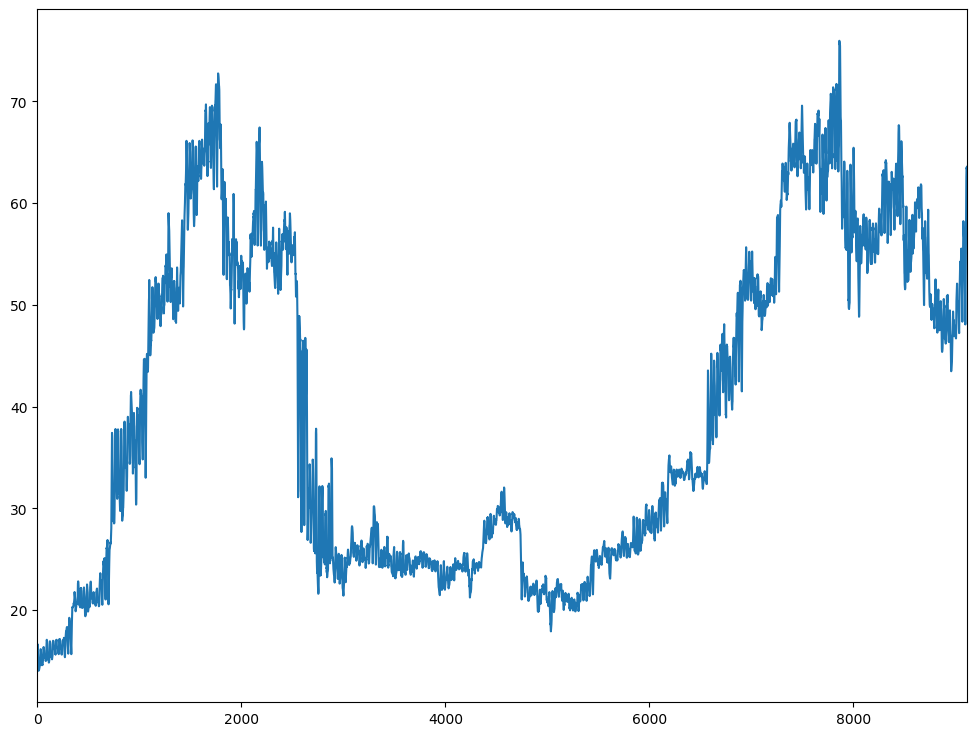

In [1050]:
avg_data["Close_40"].plot()

In [1051]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Average trend prediction model

In [ ]:
avg_data = averaging_data(stocks_timeser_skim,n_days=10,skip_col=2)

In [1083]:
values = avg_data.values[:,2:]#variation_data.values[:,2:]
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0.0001, 1.0)) #

#scaled = values
scaled = scaler.fit_transform(values)


In [1107]:
models = {}
histories = {}
tests = {}
RMSEs = {}

In [1108]:
#best = 100
low_best = 5#5#int(best - best/5)
high_best = 30#30#int(0.5*10**(np.log10(best)+1))

In [1179]:
new_values = np.logspace(np.log10(low_best),np.log10(high_best),2).astype(int)
new_values = [15]

In [1181]:
# design network
n_model = 0
n_years = 17
for n_days in new_values:
    
    if n_days in models:
        continue
    
    call_backs = [
    EarlyStopping(patience=50),
    ModelCheckpoint("model_%d.h5"%n_days,save_best_only=True),
        TqdmCallback(verbose=0)
    ]
    
    print("=======================================================")
    print("Testing Model no. %d - predicting from %d days before"%(n_model,n_days))
    print("=======================================================")
    
    print("> Data preprocessing")
    n_model = n_model + 1
    #n_days = 20
    n_features = (stocks_timeser_skim.columns.shape[0]-2)
    
    reframed = series_to_supervised(scaled, n_days, 1)

    values = reframed.values
    n_train_days = 365 * n_years #20 years
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    
    n_obs = n_days * n_features
    n_target = n_features-1
    train_X, train_y = train[:, :n_obs], train[:, -n_features+n_target]
    test_X, test_y = test[:, :n_obs], test[:, -n_features+n_target]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

    print("> Model")
    model = Sequential()
    
    #model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(train_X, train_y, epochs=200, batch_size=2048, validation_data=(test_X, test_y), verbose=0, callbacks=call_backs, shuffle=True)


    tests[n_days] = [test_X,test_y]
    models[n_days] = model
    histories[n_days] = history

Testing Model no. 0 - predicting from 150 days before
> Data preprocessing
> Model



In [1161]:
n_keys=len(histories)
theLs = list(histories.keys())

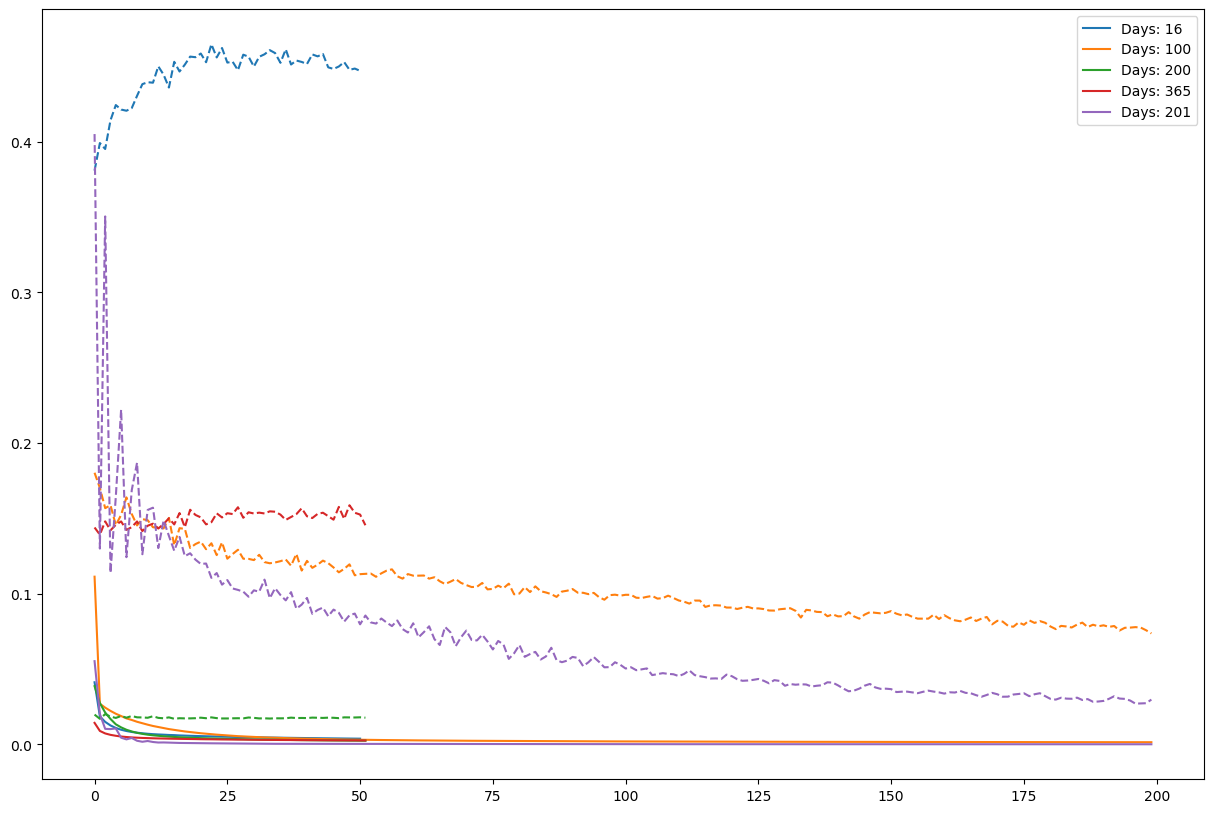

In [1162]:
colors = [""]
plt.figure(figsize=(15,10))

for k,n in zip(histories,theLs): 
    history = histories[k]
    train_loss = plt.plot(history.history['loss'],"-", label='Days: %d'%(n))[0]
    plt.plot(history.history['val_loss'],"--",color=train_loss.get_color())
    
plt.legend()
plt.show()

In [1163]:
from keras.models import load_model

In [1166]:
yhats = {}
for k in tests: 
    print(k)
    if k ==365:
        continue
    model = models[k]
    test_X = tests[k][0]
    text_y = tests[k][1]
    
    #print(model.summary())
    yhats[k] = model.predict(test_X)
    yhat = yhats[k]
    RMSEs[k] = sqrt(mean_squared_error(test_y, yhat[yhat.shape[0]-test_y.shape[0]:]))
    
    
    #train_loss = plt.plot(history.history['loss'],"-", label='Train %d'%(n))[0]
    #plt.plot(history.history['val_loss'],"--",color=train_loss.get_color(),label='Test %d '%(n))


16
100
200
365
201


W0323 23:21:40.820026 140108542539584 legend.py:1282] No handles with labels found to put in legend.


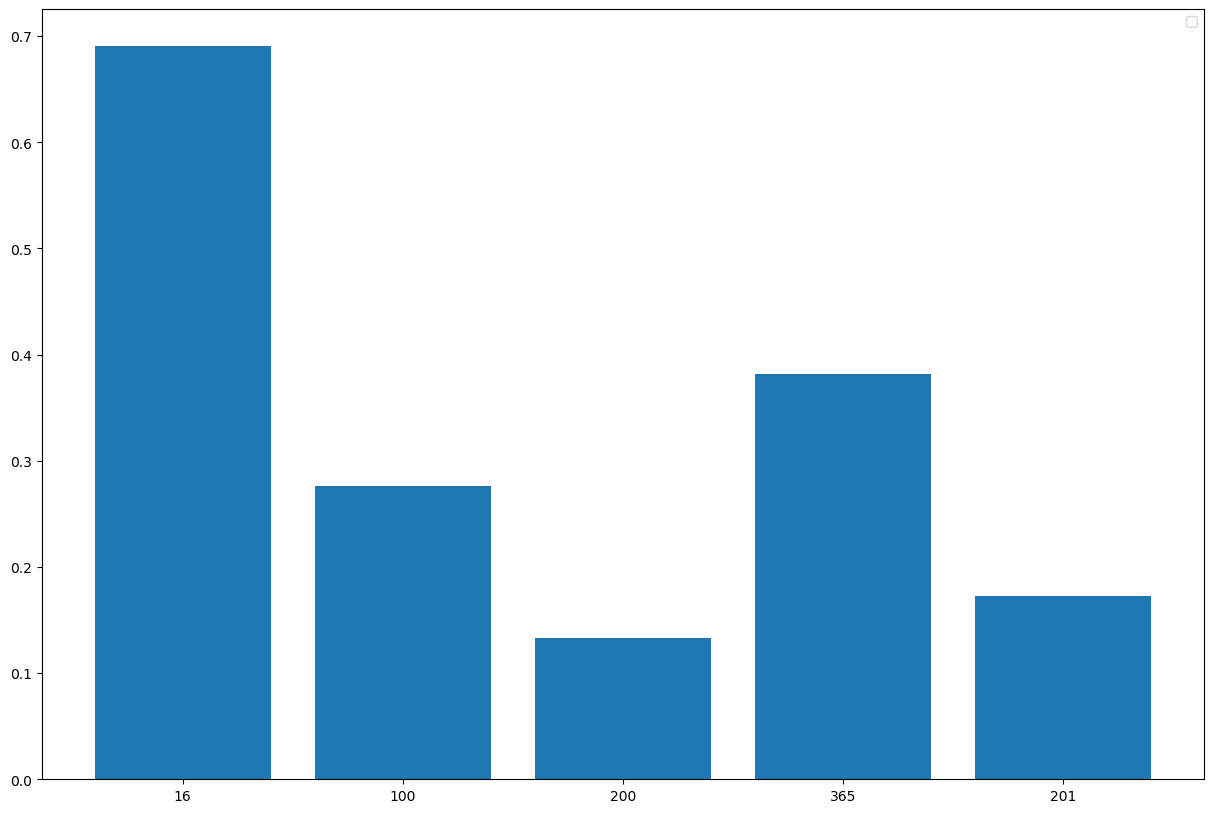

In [1167]:
plt.figure(figsize=(15,10))
plt.bar(range(n_keys),RMSEs.values())
plt.xticks(range(n_keys),labels=list(RMSEs.keys()))
plt.legend()
plt.show()

In [1168]:
best = min(RMSEs, key=RMSEs.get)
low_best = int(best - best/5)
high_best = int(0.5*10**(np.log10(best)+1))

In [1169]:
new_values = []#np.logspace(np.log10(low_best),np.log10(high_best),5).astype(int)

In [1170]:
values.shape[0]-n_train_days

2713

In [1171]:
import statsmodels.formula.api as sm

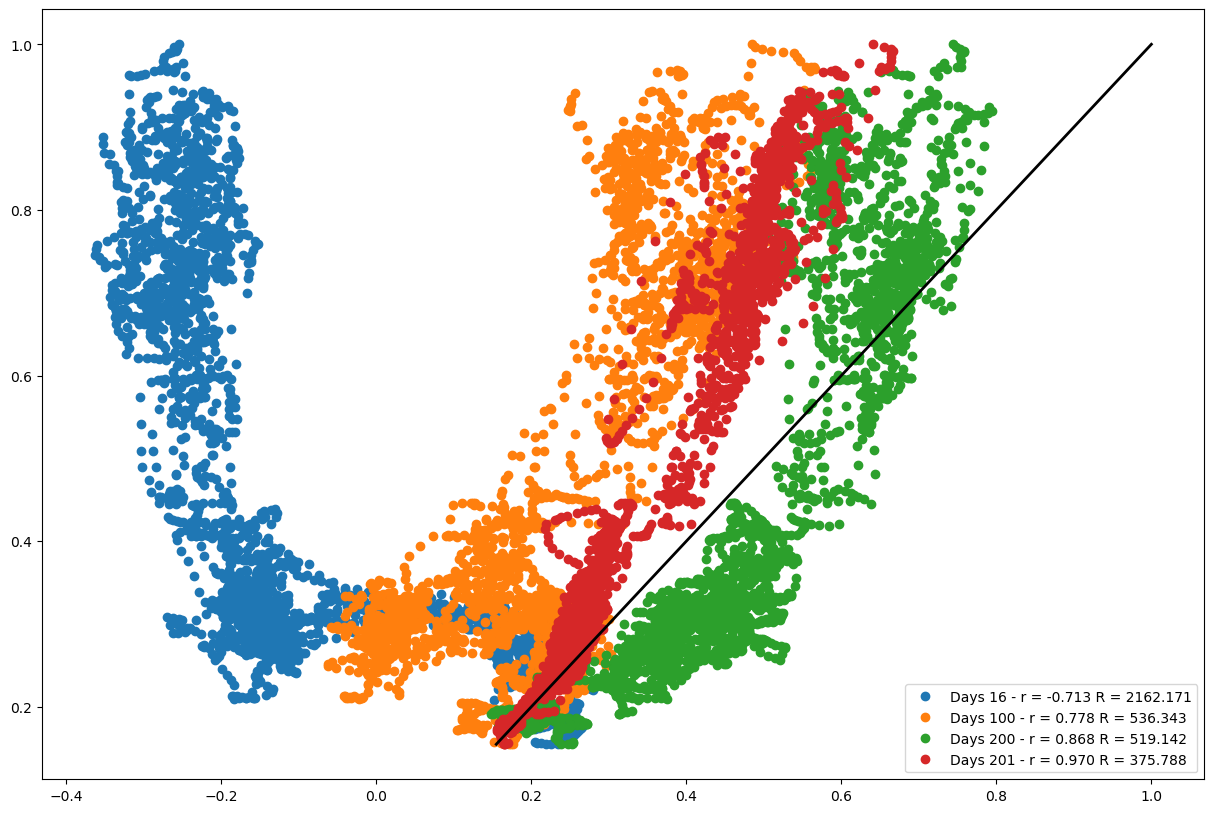

In [1173]:
plt.figure(figsize=(15,10))

for k in models: 
    if k==365:
        continue
    model = models[k]
    test = tests[k]
    #print(test.shape)
    test_X = test[0]
    text_y = test[1]
    yhat = yhats[k]
   
    
    rr = np.corrcoef(yhat[yhat.shape[0]-test_y.shape[0]:,0],test_y)[0][1]
    R = np.sum(((yhat[yhat.shape[0]-test_y.shape[0]:]- test_y)**2)/test_y)/len(test_y)
    plt.plot(yhat[yhat.shape[0]-test_y.shape[0]:],test_y,"o",label="Days %d - r = %.3f R = %.3f"%(k,rr,R))
    plt.legend()
    
plt.plot(np.linspace(min(test_y),max(test_y),20),np.linspace(min(test_y),max(test_y),20),color="black",lw=2)

In [112]:
yhat_corr.shape

(1898,)

In [106]:
test_y

array([0.11335817, 0.14555615, 0.14555615, ..., 0.49377328, 0.49377328,
       0.44720596], dtype=float32)

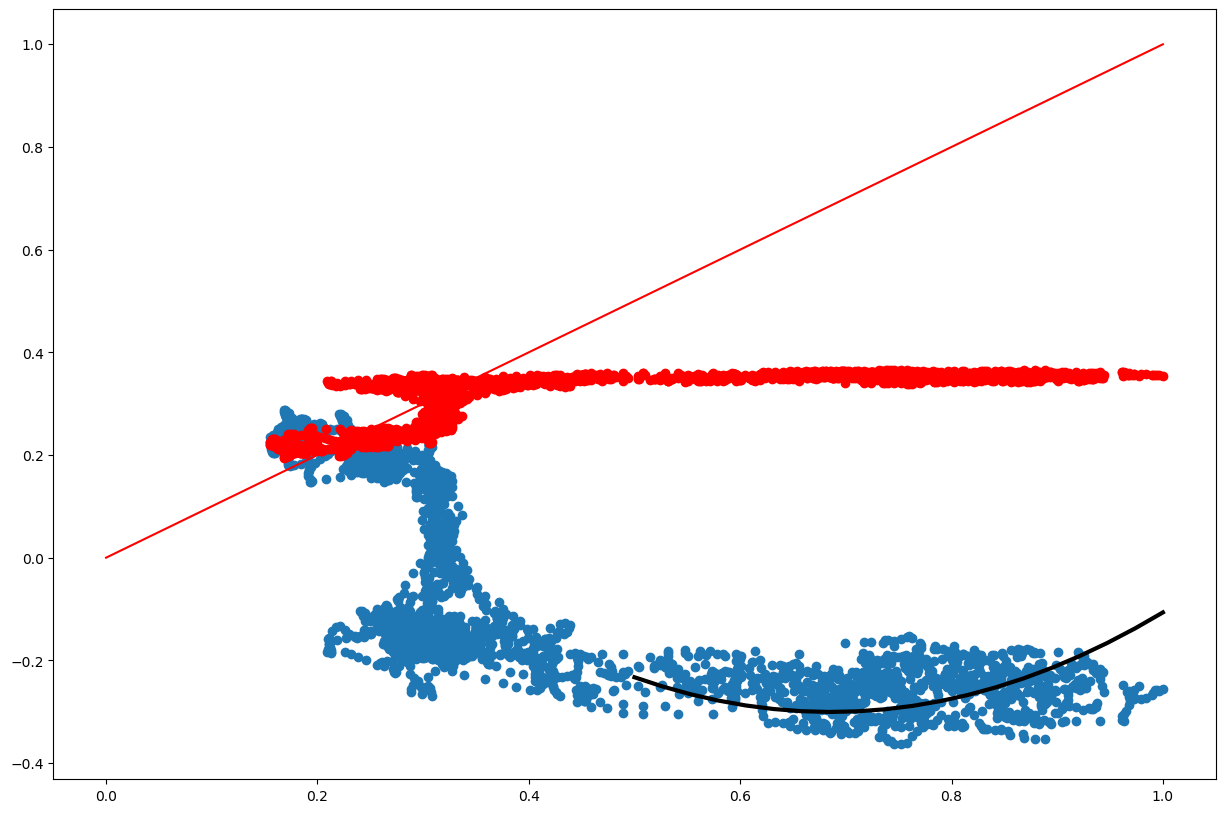

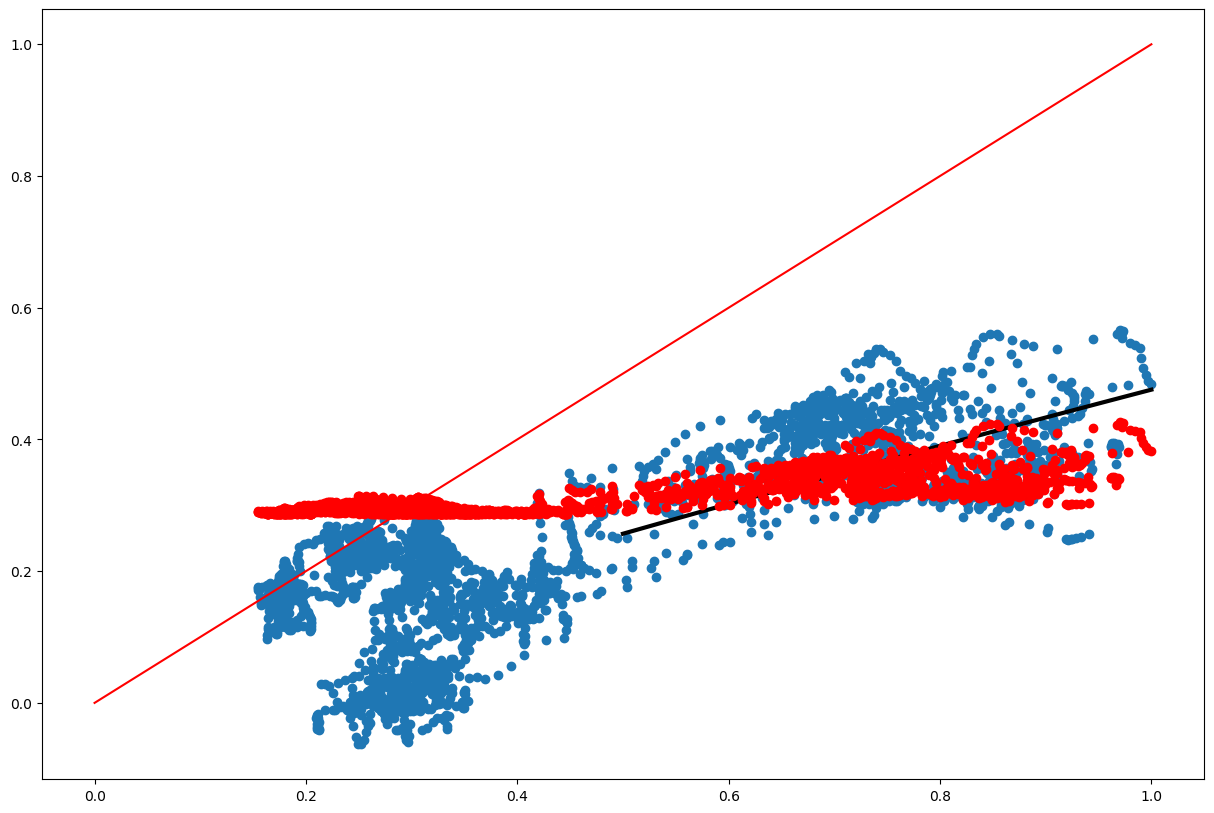

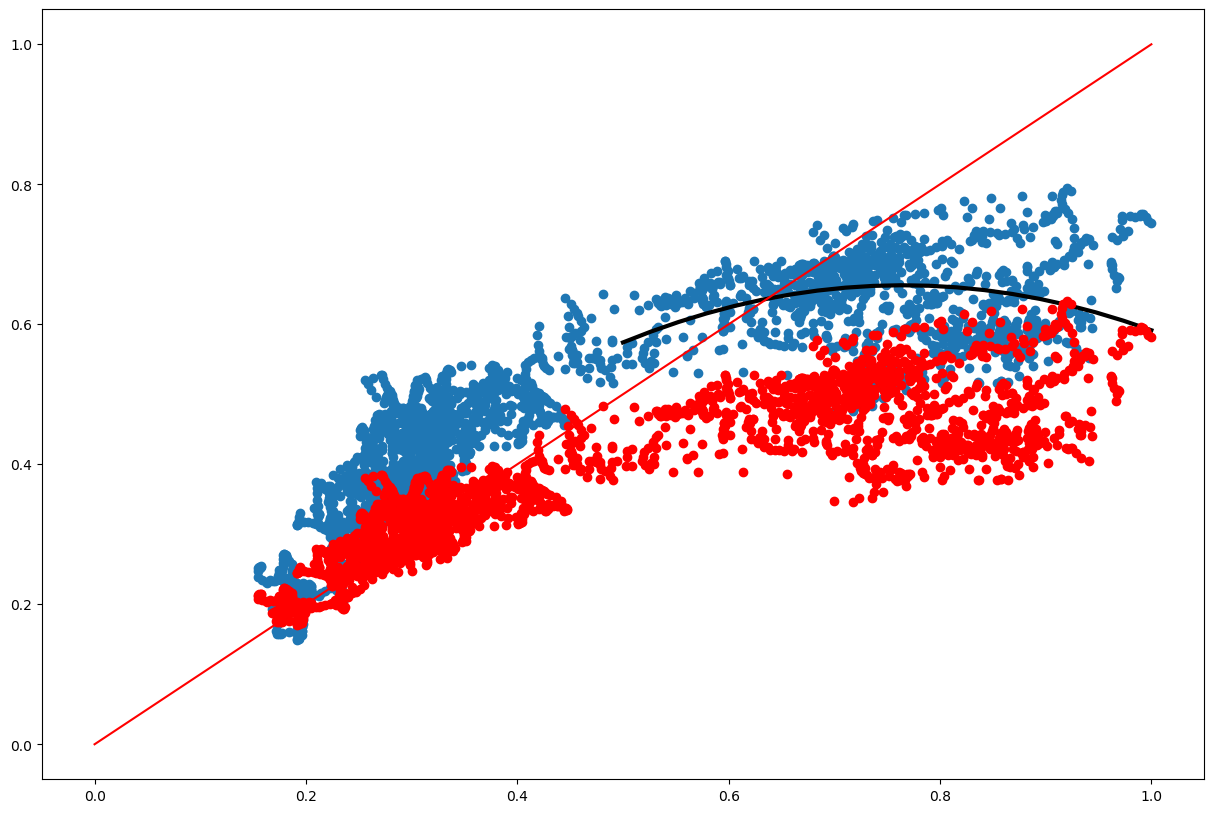

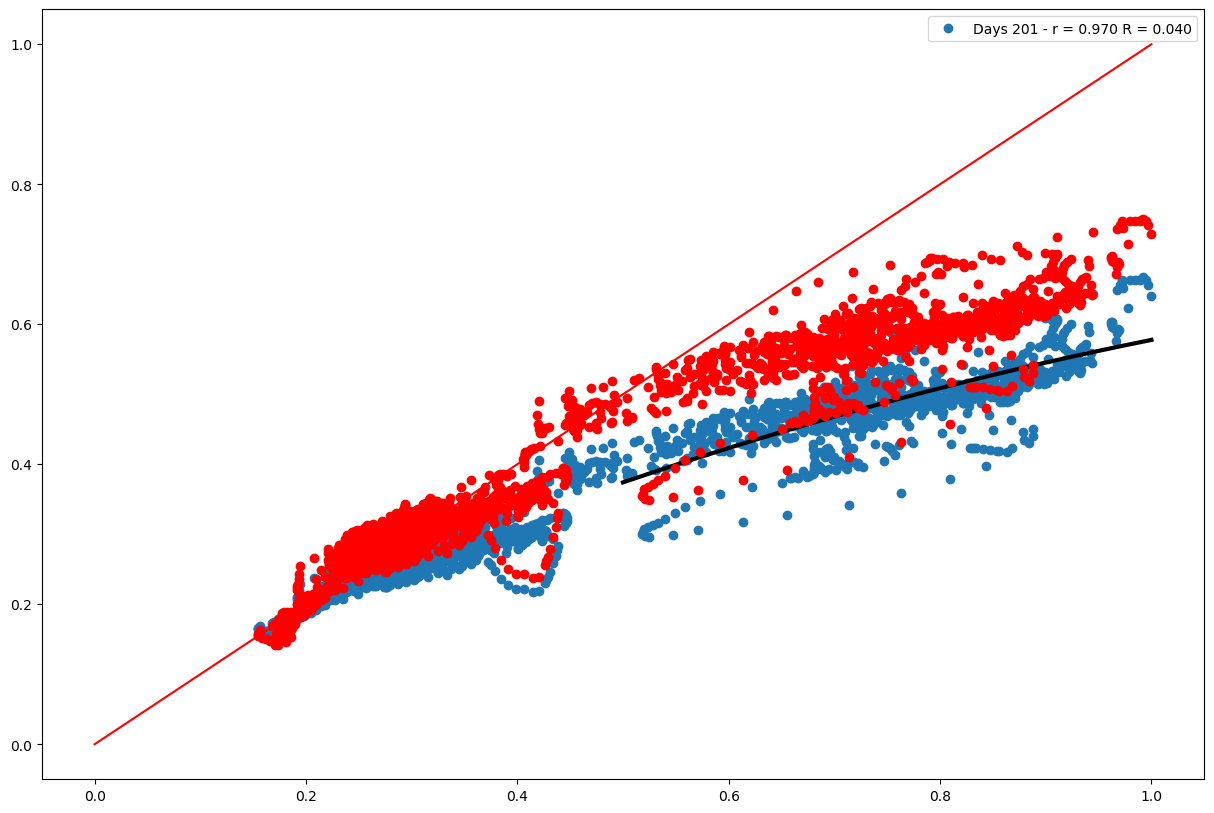

In [1174]:
yhats_corr = {}
for k in models: 
    
    if k==365:
        continue
        
    plt.figure(figsize=(15,10))

    model = models[k]
    test = tests[k]
    #print(test.shape)
    test_X = test[0]
    test_y = test[1]

    #print(model.summary())
    yhat = yhats[k].flatten()
    Y = yhat[yhat.shape[0]-test_y.shape[0]:].flatten()

    rr = np.corrcoef(test_y,Y)[0][1]
    R = np.sum(((Y- test_y)**2)/test_y)/len(test_y)
    plt.plot(test_y,Y,"o",label="Days %d - r = %.3f R = %.3f"%(k,rr,R))
    z = np.polyfit(test_y,Y,2)
    zp = np.polyfit(Y[test_y<0.5],test_y[test_y<0.5],2)

    yhat_corr = np.poly1d(zp)(Y)
    #yhat_corr[test_y<0.5]=yhat[test_y<0.5]
    yhats_corr[k] = yhat_corr
    
    plt.plot(np.linspace(0.5,1.0,20),np.poly1d(z)(np.linspace(0.5,1.0,20)),color="black",lw=3)
    plt.plot(test_y,yhat_corr,"o",color="red",lw=3)
    plt.plot(np.linspace(0.0,1.0,20),np.linspace(0.0,1.0,20),color="red")
plt.legend()

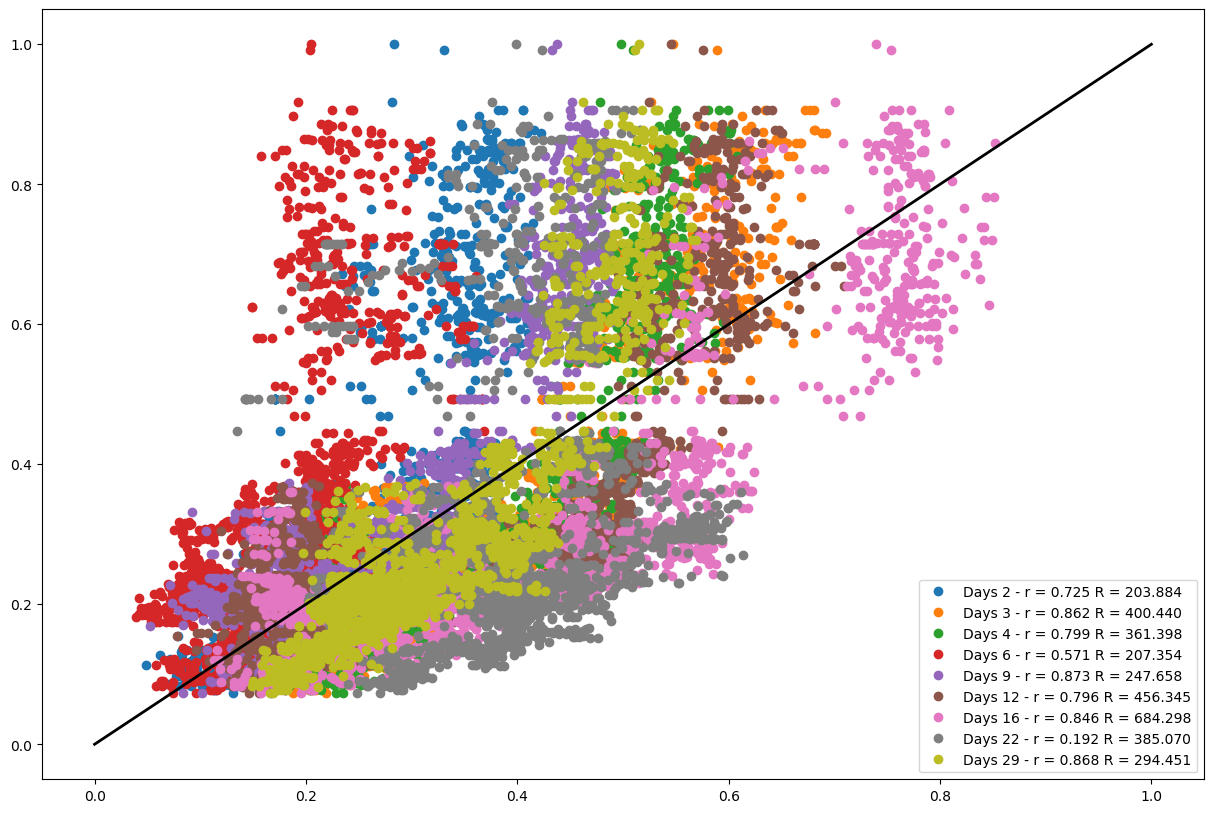

In [100]:
plt.figure(figsize=(15,10))

for k in models: 
    
    model = models[k]
    test = tests[k]
    #print(test.shape)
    test_X = test[0]
    text_y = test[1]
    yhat = yhats[k]
   
    
    rr = np.corrcoef(yhat[yhat.shape[0]-test_y.shape[0]:,0],test_y)[0][1]
    R = np.sum(((yhat[yhat.shape[0]-test_y.shape[0]:]- test_y)**2)/test_y)/len(test_y)
    plt.plot(yhat[yhat.shape[0]-test_y.shape[0]:],test_y,"o",label="Days %d - r = %.3f R = %.3f"%(k,rr,R))
    plt.legend()
    
plt.plot(np.linspace(0,1.0,20),np.linspace(0,1.0,20),color="black",lw=2)

In [ ]:
real_variation = test_y - test[0][:,-1,-1] 
estimated_variation = yhat_corr - test[0][:,-1,-1]

In [ ]:
plt.plot(real_variation)
plt.plot(estimated_variation)
plt.plot([-1.0,700.0],[0.0,0.0])

In [ ]:
for k in models: 
    plt.figure(figsize=(15,10))

    yhat = models[k].predict(tests[k][0])
    
    plt.plot(np.linspace(0.0,1.0,len(yhat)),tests[k][1])
    plt.plot(np.linspace(0.0,1.0,len(yhat)),yhat)

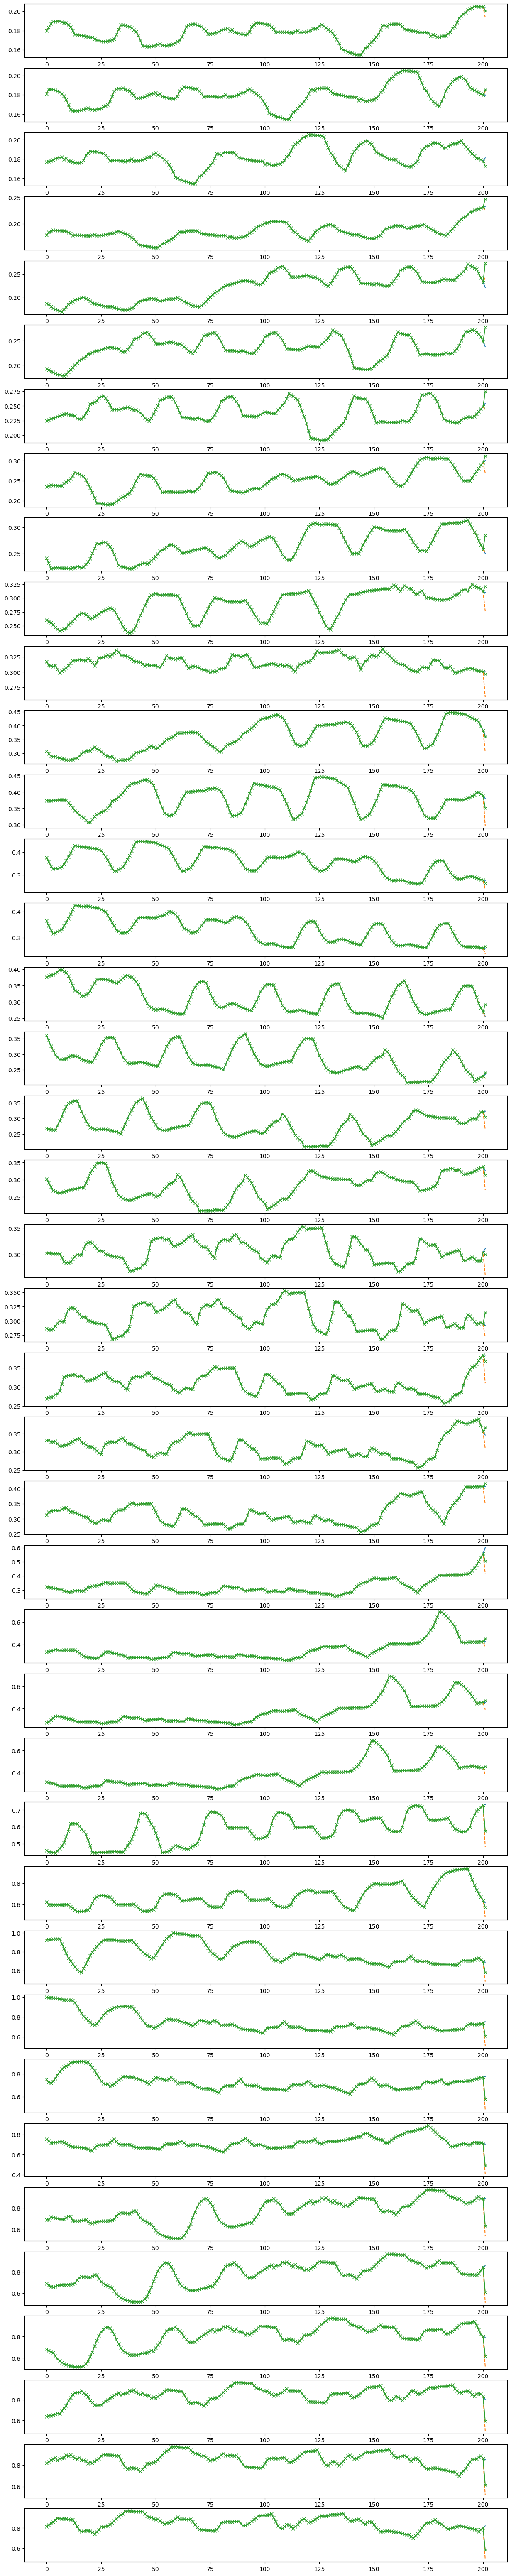

In [1177]:
u = np.unique(np.random.randint(1,test_X.shape[0],40))
plt.figure(figsize=(15,len(u)*2))
k = 201

model = models[k]
test = tests[k]
yhat = yhats[k]
test_X = test[0]
test_y = test[1]
yhat_corr = yhats_corr[k]

for n,i in enumerate(u):
    
    plt.subplot(len(u), 1, n+1)
    #plt.ylim(0.0,1.0)
    plt.plot(list(test[0][i,:,-1]) + [test_y[i]])
    plt.plot(list(test[0][i,:,-1]) + [yhat[i]],"--")
    plt.plot(list(test[0][i,:,-1]) + [yhat_corr[i]],"x-")
    

In [1145]:
import keras
from keras.constraints import max_norm

In [ ]:
days = [7,14,30]

n_features = len(good_cols_ser)

model = Sequential()

LSTMs = []
INPUTs = []
for n_days in days:
    
    input_layer = Input(shape=(n_days, n_features))
    INPUTs.append(input_layer)
    lstm = LSTM(25)(input_layer)
    LSTMs.append(lstm)
    
concat = keras.layers.concatenate(LSTMs)
b_norm = BatchNormalization()(concat)
dense = Dense(32, kernel_constraint=max_norm(1.0))(b_norm)
pred  = Dense(len(days), kernel_constraint=max_norm(1.0))(dense)

model = Model(inputs=INPUTs, outputs=pred)
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.summary()

In [ ]:


call_backs = [
EarlyStopping(patience=50),
ModelCheckpoint("model_7_14_30_90.h5",save_best_only=True),
    TqdmCallback(verbose=0)
]

print("===================================================================")
print("Testing Model Multipe - predicting from multiple sets of days before")
print("===================================================================")



#n_days = 20


training_X = []
testing_X = []

training_y = []
testing_y = []

min_samples_train = 1e10 
min_samples_test = 1e10

for n_days in days:
    
    print("> Data preprocessing - n_days %d"%n_days)
    reframed = series_to_supervised(scaled, n_days, 1)

    values = reframed.values
    n_train_days = 365 * 20 #20 years
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]

    n_obs = n_days * n_features
    n_target = n_features-1
    train_X, train_y = train[:, :n_obs], train[:, -n_features+n_target]
    test_X, test_y = test[:, :n_obs], test[:, -n_features+n_target]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
    
    training_X.append(train_X)
    testing_X.append(test_X)
    
    training_y.append(train_y)
    testing_y.append(test_y)
    
    min_samples_train = min(min_samples_train,train_X.shape[0])
    min_samples_test = min(min_samples_test,test_X.shape[0])

fixed_testing_X = []
fixed_training_X = []
fixed_testing_y = []
fixed_training_y = []

LCM = np.lcm.reduce(n_days)

for t in testing_X:
    fixed_testing_X.append(t[-min_samples_test:])
for t in training_X:
    fixed_training_X.append(t[-min_samples_train:])
    
for t in testing_y:
    fixed_testing_y.append(t[-min_samples_test:])
for t in training_y:
    fixed_training_y.append(t[-min_samples_train:])

fixed_testing_y = np.array(fixed_testing_y).T
fixed_training_y = np.array(fixed_training_y).T

training_X = []
testing_X = []

training_y = []
testing_y = []

history = model.fit(fixed_training_X, fixed_training_y, epochs=1000, batch_size=256, validation_data=(fixed_testing_X, fixed_testing_y), verbose=0, callbacks=call_backs, shuffle=False)


tests[n_days] = [test_X,test_y]
models[n_days] = model
histories[n_days] = history

In [ ]:
colors = [""]
plt.figure(figsize=(15,10))

for k,n in zip(histories,theLs): 
    history = histories[k]
    train_loss = plt.plot(history.history['loss'],"-", label='Days: %d'%(n))[0]
    plt.plot(history.history['val_loss'],"--",color=train_loss.get_color())
    
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(fixed_testing_X)

In [ ]:
plt.figure(figsize=(15,10))
y_corr = []
for Y,test_y in zip(list(yhat.T),list(fixed_testing_y.T)):
#Y = yhat[yhat.shape[0]-test_y.shape[0]:].flatten()

    rr = np.corrcoef(test_y,Y)[0][1]
    R = np.sum(((Y- test_y)**2)/test_y)/len(test_y)
    #l = plt.plot(test_y,Y,"o",label="Days %d - r = %.3f R = %.3f"%(k,rr,R))
    z = np.polyfit(test_y,Y,2)
    zp = np.polyfit(Y,test_y,2)

    yhat_corr = np.poly1d(zp)(Y)
    y_corr.append(yhat_corr)
    l = plt.plot(np.linspace(-0.5,1.0,20),np.poly1d(z)(np.linspace(0,1.0,20)),lw=3)
    plt.plot(test_y,yhat_corr,"X",color=l[0].get_color(),lw=3)
    
plt.plot(np.linspace(-0.5,1.0,20),np.linspace(-0.5,1.0,20),color="red")
plt.legend()

In [ ]:
for Y,test_y,test_X,y in zip(list(yhat.T),list(fixed_testing_y.T),fixed_testing_X,y_corr):
    #print(test_X.shape)
    #u = np.unique(np.random.randint(1,test_X[0].shape[0],100))
    print(test_X.shape)
    plt.figure(figsize=(15,50))
    plt.title(str(test_X.shape[1]))
    for n,i in enumerate(range(10)):
        plt.subplot(10, 1, n+1)
        plt.plot(list(test_X[i,:,-1]) + [test_y[i]])
        plt.plot(list(test_X[i,:,-1]) + [Y[i]],"--")
        plt.plot(list(test_X[i,:,-1]) + [y[i]],"x-")
        
    plt.show()